In [83]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from source.tserie import TSerie

from source.torch_utils import getContrastiveFeatures

import sys

sys.path.append('/home/texs/Documentos/Repositories/ts2vec')



In [109]:
from source.datasets import loadFuncionalModel, loadNatops, loadWafer, loadSelfRegulationSCP2, loadBasicMotions, loadEarthquakes, loadItalyPowerDemand, loadEigenWorms

dataset = 'wafer' # natops | wafer | selfreg | basicmotions | earthquakes | italy | eigenworms

settings = {
    'natops' : {
        'epochs': 150,
        'filters' : [32, 64],
        'kernels' : [5, 5],
        'feat_size' : 256,
        'enc_size' : 20,
    },
    'wafer' : {
        'epochs': 20,
        'filters' : [16, 32],
        'kernels' : [5, 5],
        'feat_size' : 512,
        'enc_size' : 20,
    },
    'basicmotions' : {
        'epochs': 200,
        'filters' : [16, 32],
        'kernels' : [5, 5],
        'feat_size' : 128,
        'enc_size' : 20,
    },
    'italy' : {
        'epochs': 200,
        'filters' : [16],
        'kernels' : [5],
        'feat_size' : 128,
        'enc_size' : 8,
    }
}

if dataset == 'natops':
    X_train, y_train, X_test, y_test, classLabels = loadNatops()
elif dataset == 'wafer':
    X_train, y_train, X_test, y_test = loadWafer()
    classLabels = {}
elif dataset == 'basicmotions':
    X_train, y_train, X_test, y_test, classLabels= loadBasicMotions()
elif dataset == 'italy':
    X_train, y_train, X_test, y_test, classLabels= loadItalyPowerDemand()
# X = np.concatenate([X_train, X_test], axis=0).transpose([0, 2, 1])
# y = np.concatenate([y_train, y_test], axis=0)
# y = np.array([float(v) for v in y]).astype(int).tolist()

In [110]:
mts_train = TSerie(X=X_train.transpose([0, 2, 1]), y=y_train)
mts_test = TSerie(X=X_test.transpose([0, 2, 1]), y=y_test)

Loaded mts - N: 1000, T: 152, D: 1 
Loaded mts - N: 6164, T: 152, D: 1 


In [111]:
# mts.smooth(window_size=40)
# mts_train.shapeNormalizization()
# mts_test.shapeNormalizization()
# mts_train.minMaxNormalizization()
# mts_test.minMaxNormalizization()
minl, maxl = mts_train.minMaxNormalizization()
minl, maxl = mts_test.minMaxNormalizization(minl= minl, maxl=maxl)

In [112]:
from source.featlearn.simclr import SimClrFL
from source.featlearn.weakStrongFL import WeakStrongFL
from ts2vec import TS2Vec

# Train a TS2Vec model
model = TS2Vec(
    input_dims=mts_train.D,
    device=0,
    output_dims=128,
)




# in_channels = mts_train.D
# in_time = mts_train.T
# # encoder = SimClrFL(in_channels, in_time)
# encoder = SimClrFL(in_channels, in_time, encoding_size = 8, feature_size=128, filters = [8, 8],
#             kernels = [5, 5],)

In [113]:
# encoder.reviewAugmentations(mts_train.X.transpose([0, 2, 1]))

In [114]:
# encoder.fit(mts_train.X.transpose([0, 2, 1]), 
#             epochs=200, 
#             batch_size=128
# )


loss_log = model.fit(
    mts_train.X,
    verbose=True
)

Epoch #0: loss=2.9405838328023113
Epoch #1: loss=2.6516595386689708
Epoch #2: loss=2.338978255948713
Epoch #3: loss=2.145258838130582
Epoch #4: loss=2.030718395786901
Epoch #5: loss=1.9101206679497995
Epoch #6: loss=1.7143012381369067
Epoch #7: loss=1.7672265441186967
Epoch #8: loss=1.4833608615782954


In [115]:
# mts_train.features = encoder.encode(mts_train.X.transpose([0, 2, 1]))
# mts_test.features = encoder.encode(mts_test.X.transpose([0, 2, 1]))

mts_train.features = model.encode(mts_train.X, encoding_window='full_series')
mts_test.features = model.encode(mts_test.X, encoding_window='full_series')


In [116]:
from sklearn import svm
from sklearn.metrics import f1_score

clf = svm.SVC()
clf.fit(mts_train.features, mts_train.y)

print('accuracy')
print(clf.score(mts_train.features, mts_train.y))
print(clf.score(mts_test.features, mts_test.y))

print('f1 score')
print(f1_score(clf.predict(mts_train.features), mts_train.y, average= 'weighted'))
print(f1_score(clf.predict(mts_test.features), mts_test.y, average= 'weighted'))

accuracy
0.987
0.9800454250486696
f1 score
0.9874203967330724
0.9806963432545055


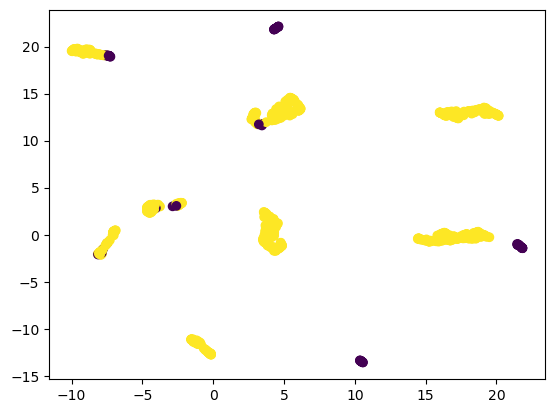

In [117]:
import matplotlib.pyplot as plt
import umap

# reducer = umap.UMAP(n_components=2, metric='cosine')
reducer = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=15)
reducer.fit(mts_train.features, y = mts_train.y)
coords_train = reducer.transform(mts_train.features)
coords_test = reducer.transform(mts_test.features)

plt.scatter(coords_train[:, 0], coords_train[:, 1], c=mts_train.y)


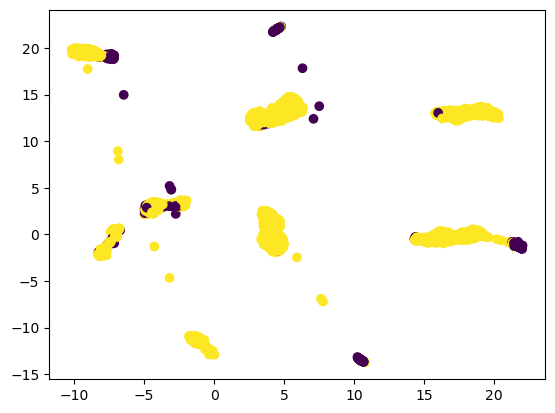

In [118]:
plt.scatter(coords_test[:, 0], coords_test[:, 1],  c=mts_test.y)

In [19]:
import sys
sys.path.append('/home/texs/Documentos/Repositories/mts_viz')
from server.source.storage import MTSStorage

In [20]:
storage = MTSStorage('mts_comparison')    
# storage.delete()
storage.load()

# classLabels = {int(v): str(v) for v in np.unique(y)}
dimensions = [str(dim) for dim in range(mts_train.D)]
# dimensions = [sPoll, sPoll + '_norm']
# dimensions = pollutants + [poll + '_norm' for poll in pollutants]
data = np.concatenate([mts_train.X_orig, mts_train.X], axis=2) 
storage.add_mts(
    '{}_{}_{}_train'.format(dataset, LOSS, MODE),
    data, 
    dimensions = dimensions + [dim+ '_norm' for dim in dimensions], 
    labels = {'class': mts_train.y},
    labelsNames = {'class': classLabels},
    coords = {
        'shape': coords_train,
    },
    sampling=True,
    n_samples= 400
)

data = np.concatenate([mts_test.X_orig, mts_test.X], axis=2) 
storage.add_mts(
    '{}_{}_{}_test'.format(dataset, LOSS, MODE),
    data, 
    dimensions = dimensions + [dim+ '_norm' for dim in dimensions], 
    labels = {'class': mts_test.y},
    labelsNames = {'class': classLabels},
    coords = {
        'shape': coords_test,
    },
    sampling=True,
    n_samples= 400
)


storage.save()

mts shape: N: 67 -  T: 24 - D: 2
mts shape: N: 1029 -  T: 24 - D: 2
